In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import torch
from torch import nn
from torch.optim import SGD
from torch.utils.data import TensorDataset, DataLoader

from IPython.display import clear_output

In [2]:
data = pd.read_csv("data/insurance.csv")
X, y = data.drop("charges", axis=1), data["charges"]

encoder = OneHotEncoder()
encoder.fit(X)

scaler = StandardScaler()
X_one_hot = np.array(encoder.transform(X).todense())

X_train, X_test, y_train, y_test = train_test_split(X_one_hot, y, test_size=0.25)

scaler.fit(y_train.to_numpy()[:, None])
y_train = scaler.transform(y_train.to_numpy()[:, None])
y_test = scaler.transform(y_test.to_numpy()[:, None])

In [3]:
X_torch_train = torch.Tensor(X_train)
X_torch_test = torch.Tensor(X_test)
y_torch_train = torch.Tensor(y_train)
y_torch_test = torch.Tensor(y_test)

### Linear Regression

In [4]:
cfg_model = {
    "layers":[
        nn.Linear(X_torch_train.shape[1], 1),
    ],
}

cfg_opt = {
    "lr":0.01
}

cfg_loader = {
    "batch_size":128,
    "shuffle":True
}

cfg_train = {
    "n_epoches":1000,
}

In [5]:
model = nn.Sequential(
    *cfg_model["layers"]
)

opt = SGD(model.parameters(), **cfg_opt)
l2 = nn.MSELoss(reduction="sum")

In [6]:
dataset_train = TensorDataset(X_torch_train, y_torch_train)
dataloader_train = DataLoader(dataset_train, **cfg_loader)

dataset_test = TensorDataset(X_torch_test, y_torch_test)
dataloader_test = DataLoader(dataset_test, **cfg_loader)

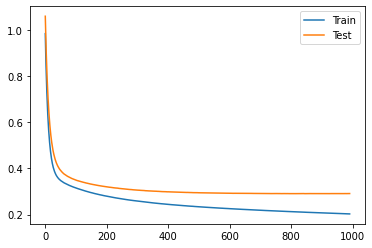

In [7]:
losses_train = []
losses_test = []

loss_tmp = 0
n_elem = 0

for i in range(cfg_train["n_epoches"]):
    loss_tmp = 0
    n_elem = 0
    
    for X_batch, y_batch in dataloader_train:
        opt.zero_grad()
        n = X_batch.shape[0]
        loss = l2(model(X_batch), y_batch)/n
        loss.backward()
        opt.step()
        loss_tmp += loss.item()*n
        n_elem += n
        
    losses_train.append(loss_tmp/n_elem)

    with torch.no_grad():
        loss_tmp = 0
        n_elem = 0

        for X_batch, y_batch in dataloader_test:
            loss = l2(model(X_batch), y_batch)
            loss_tmp += loss.item()
            n_elem += X_batch.shape[0]

        losses_test.append(loss_tmp/n_elem)
        
    if not i%10:
        clear_output(wait=True)
        plt.plot(losses_train, label="Train")
        plt.plot(losses_test, label="Test")
        plt.legend()
        plt.show()

### Normalizing flow

In [8]:
from torch.distributions import Exponential, Gamma

In [9]:
class CouplingLayer(nn.Module):
    
    def __init__(self, c_in, idx_in):
        super().__init__()
        n_1 = len(idx_in)
        
        mask = torch.ones(c_in)
        mask[idx_in]=0
        
        self.idx_1 = idx_in
        self.idx_2 = torch.nonzero(mask).flatten()
        
        self.s = nn.Sequential(
            nn.Linear(n_1, c_in - n_1, bias=False)
        )
        
        self.t = nn.Sequential(
            nn.Linear(n_1, c_in - n_1, bias=False)
        ) 
        
    def forward(self, z, ldj, reverse=False):
        z_in = z[:, self.idx_1]
        z_out = z[:, self.idx_2]
        s, t = self.s(z_in), self.t(z_in)
        s = torch.sigmoid(s)
        # Affine transformation
        if not reverse:
            z[:, self.idx_2] = t + z_out * torch.exp(s)
            ldj += s.sum(dim=[1])
        else:
            z[:, self.idx_2] = (z_out - t) / torch.exp(s)
            ldj -= s.sum(dim=[1])

        return z, ldj

In [10]:
odd = torch.arange(0, 2, step=2)
even = torch.arange(1, 2, step=2)

layer_odd = CouplingLayer(2, odd)
layer_even = CouplingLayer(2, even)

exp = Exponential(torch.tensor(0.01))
gt_exp = exp.sample((10000, 24))

gamma = Gamma(5, 0.5)
gt_gamma = gamma.sample((10000, 24))

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

In [53]:
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()
        
        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])
        
    def g(self, z):
        x = z
        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            s = self.s[i](x_)*(1 - self.mask[i])
            t = self.t[i](x_)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x

    def f(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](z_) * (1-self.mask[i])
            t = self.t[i](z_) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J
    
    def log_prob(self,x):
        z, logp = self.f(x)
        return self.prior.log_prob(z) + logp
        
    def sample(self, batchSize): 
        z = self.prior.sample((batchSize, 1))
        logp = self.prior.log_prob(z)
        x = self.g(z)
        return x

In [62]:
nets = lambda: nn.Sequential(nn.Linear(2, 1024), nn.LeakyReLU(), nn.Linear(1024, 2), nn.Tanh())
nett = lambda: nn.Sequential(nn.Linear(2, 1024), nn.LeakyReLU(), nn.Linear(1024, 2))
masks = torch.from_numpy(np.array([[0, 1], [1, 0]] * 3).astype(np.float32))
prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
flow = RealNVP(nets, nett, masks, prior)

In [63]:
optNVP = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=1e-4)
schedNVP = torch.optim.lr_scheduler.ExponentialLR(optNVP, gamma=0.1)
for e in (pbar := tqdm(range(5001))):   
    noisy_moons = datasets.make_moons(n_samples=100, noise=.05)[0].astype(np.float32)
    loss = -flow.log_prob(torch.from_numpy(noisy_moons)).mean()
    
    optNVP.zero_grad()
    loss.backward(retain_graph=True)
    optNVP.step()
    
    pbar.set_description('loss = %.3f' % loss)
    if t % 1000 == 0:
        schedNVP.step()

loss = 0.614: 100%|██████████| 5001/5001 [04:40<00:00, 17.82it/s]


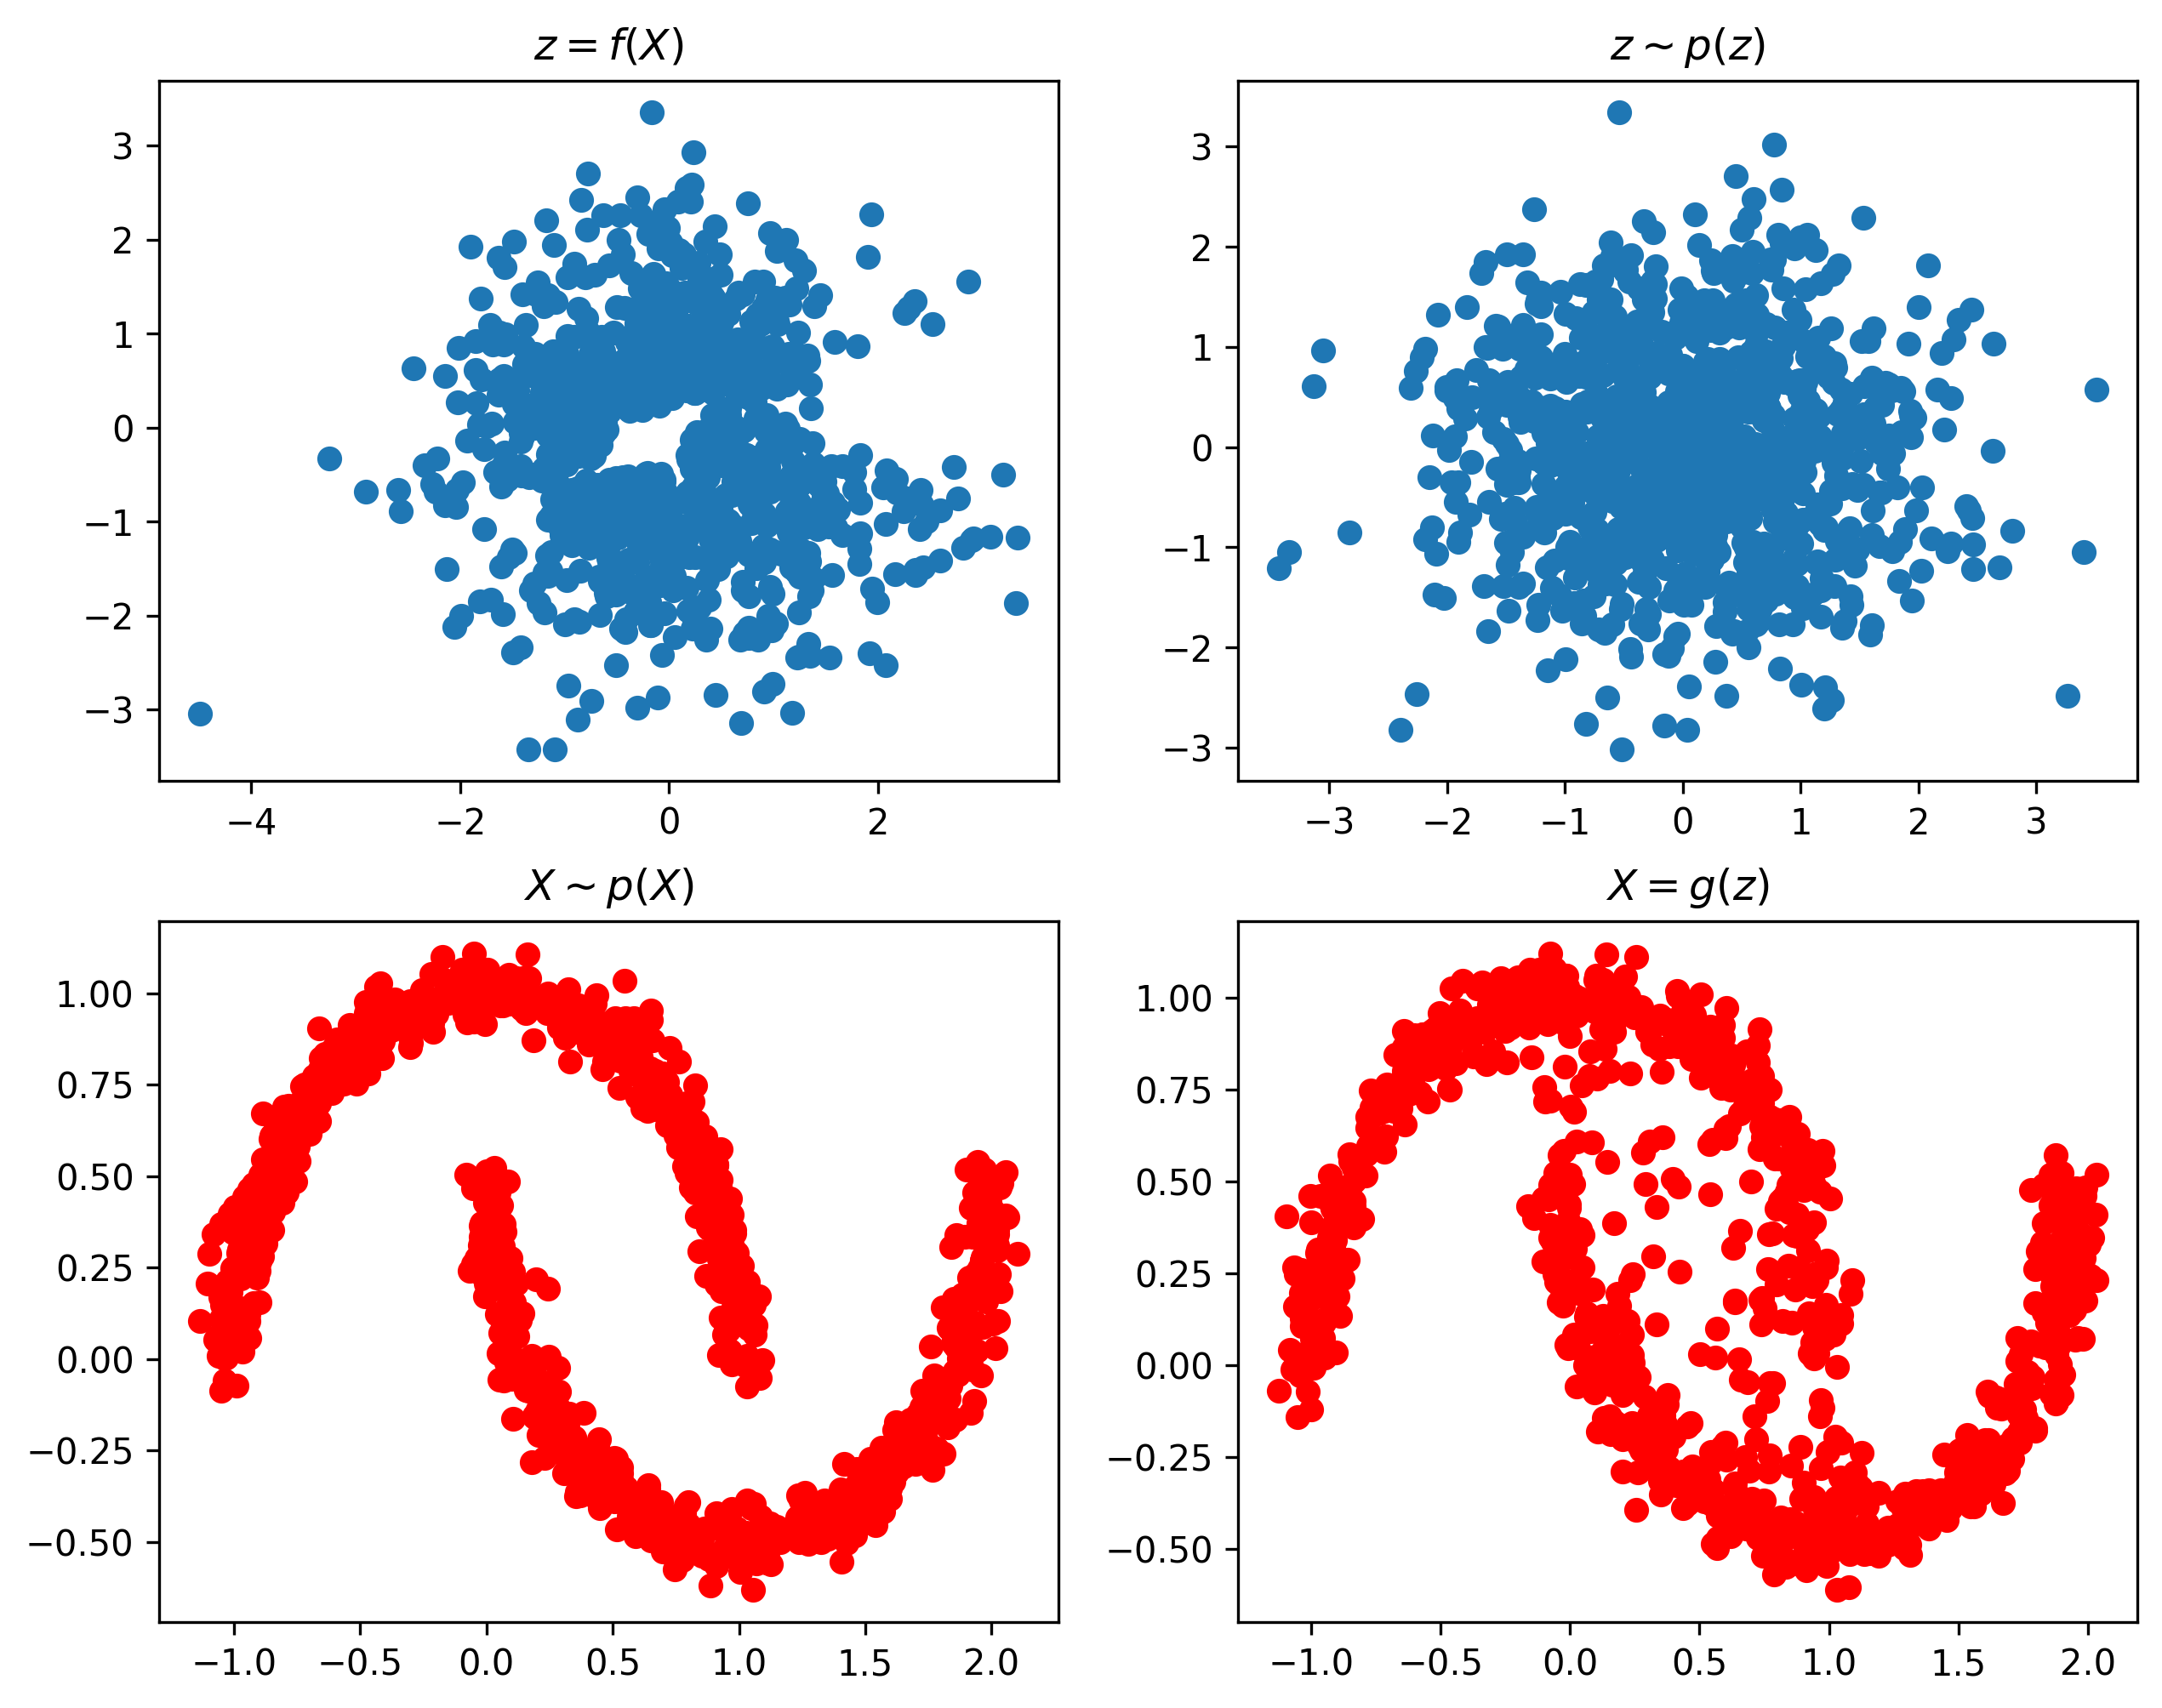

In [64]:
noisy_moons = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
z = flow.f(torch.from_numpy(noisy_moons))[0].detach().numpy()
plt.subplot(221)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z = f(X)$')

z = np.random.multivariate_normal(np.zeros(2), np.eye(2), 1000)
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z \sim p(z)$')

plt.subplot(223)
x = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
plt.scatter(x[:, 0], x[:, 1], c='r')
plt.title(r'$X \sim p(X)$')

plt.subplot(224)
x = flow.sample(1000).detach().numpy()
plt.scatter(x[:, 0, 0], x[:, 0, 1], c='r')
plt.title(r'$X = g(z)$')
plt.show()